<a href="https://colab.research.google.com/github/OmarRodriguezLopez1398/ML_Corrections_Reactions_Training/blob/main/notebook_coimbra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

! uv pip install mace-torch data-tutorials weas_widget tblite==0.4.0 rdkit  --system
get_ipython().kernel.do_shutdown(restart=True)

! pip install ase

Using Python 3.12.12 environment at: /usr
Audited 5 packages in 180ms


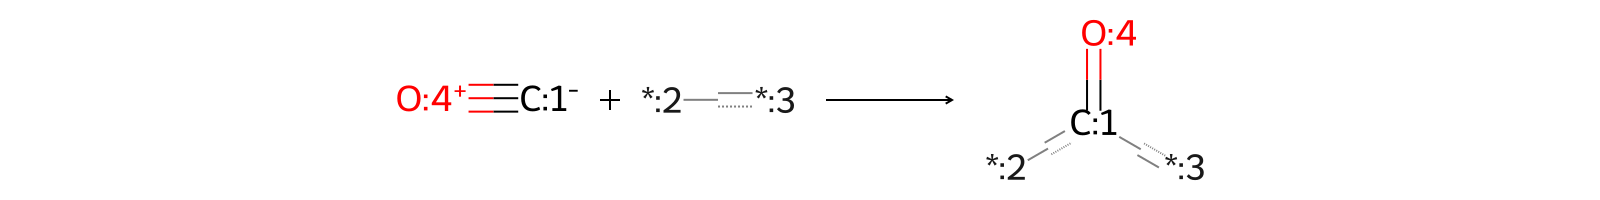

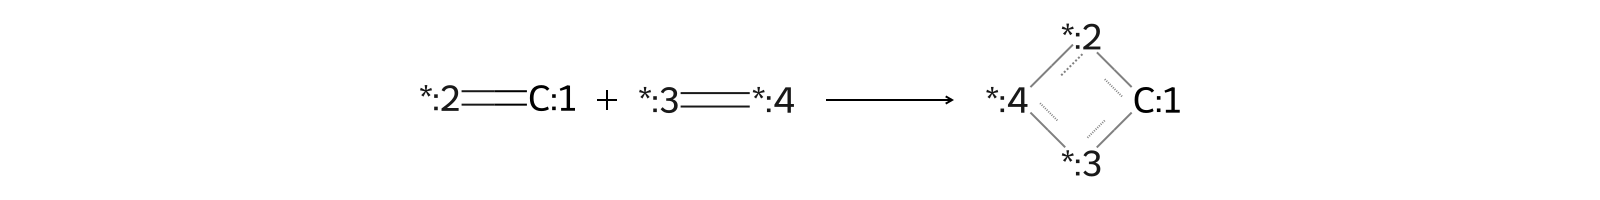

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdChemReactions, Draw
from IPython.display import display

# --------------------------------------------------
# Reacciones con centros reactivos explícitos
# --------------------------------------------------

rxn_dict = {
    # 1,2 CO insertion con carga formal en reactivos
    "1,2 CO Insertion": "[C-:1]#[O+:4].[*:2][*:3]>>[*:2][C:1](=[O:4])[*:3]",

    # 2+2 Cycloaddition genérica, usando R genéricos
    "2+2 Cycloaddition": "[C:1]=[*:2].[*:3]=[*:4]>>[C:1]1[*:3][*:4][*:2]1"
}

# Convertimos SMARTS a objetos de reacción RDKit
reactions = {name: rdChemReactions.ReactionFromSmarts(rxn) for name, rxn in rxn_dict.items()}

# --------------------------------------------------
# Dibujar las reacciones
# --------------------------------------------------
for name, rxn in reactions.items():
    img = Draw.ReactionToImage(rxn, subImgSize=(400, 200))
    display(img)


In [2]:
# 1️⃣ Clonar el repositorio si aún no se ha clonado
!git clone https://github.com/OmarRodriguezLopez1398/ML_Corrections_Reactions_Training.git

import os

# 2️⃣ Carpeta raíz de datos
base_path = "ML_Corrections_Reactions_Training/DATA"

# Listado de carpetas de reacciones
reaction_folders = ["1,2_Insertion_CO", "2+2_cycloaddition"]

# Diccionario para guardar archivos por carpeta
all_reactions = {}

for folder in reaction_folders:
    xyz_folder = os.path.join(base_path, folder)

    # Listar archivos xyz
    files = sorted([f for f in os.listdir(xyz_folder) if f.endswith(".xyz")])
    print(f"\nCarpeta: {folder}")
    print(f"{len(files)} archivos XYZ encontrados")

    # Separar por tipo
    reactivos = sorted([f for f in files if f.startswith("r_")])
    transiciones = sorted([f for f in files if f.startswith("ts_")])
    productos = sorted([f for f in files if f.startswith("prod_")])

    print("Ejemplos de archivos por tipo:")
    print("Reactivos:", reactivos[:5])
    print("TS:", transiciones[:5])
    print("Productos:", productos[:5])

    # Guardar en diccionario
    all_reactions[folder] = {
        "path": xyz_folder,
        "reactivos": reactivos,
        "transiciones": transiciones,
        "productos": productos
    }



Cloning into 'ML_Corrections_Reactions_Training'...
remote: Enumerating objects: 382, done.
remote: Counting objects: 100% (382/382), done.
remote: Compressing objects: 100% (379/379), done.
remote: Total 382 (delta 5), reused 371 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (382/382), 1.25 MiB | 2.02 MiB/s, done.
Resolving deltas: 100% (5/5), done.

Carpeta: 1,2_Insertion_CO
136 archivos XYZ encontrados
Ejemplos de archivos por tipo:
Reactivos: ['r_rxn000075_dft_1.xyz', 'r_rxn000623_dft_1.xyz', 'r_rxn001540_dft_1.xyz', 'r_rxn001668_dft_1.xyz', 'r_rxn001788_dft_1.xyz']
TS: ['ts_rxn000075_dft_1.xyz', 'ts_rxn000623_dft_1.xyz', 'ts_rxn001540_dft_1.xyz', 'ts_rxn001668_dft_1.xyz', 'ts_rxn001788_dft_1.xyz']
Productos: ['prod_rxn000075_dft_1.xyz', 'prod_rxn000075_dft_2.xyz', 'prod_rxn000623_dft_1.xyz', 'prod_rxn000623_dft_2.xyz', 'prod_rxn001540_dft_1.xyz']

Carpeta: 2+2_cycloaddition
236 archivos XYZ encontrados
Ejemplos de archivos por tipo:
Reactivos: ['r_rxn000334_dft_1.xyz',

In [3]:
from ase.io import read, write
import os
import random
from collections import defaultdict

# -----------------------------
# Configuración
# -----------------------------
base_path = "ML_Corrections_Reactions_Training/DATA"
reaction_folders = ["1,2_Insertion_CO", "2+2_cycloaddition"]
combined_xyz = "all_reaction_configs_random_both.xyz"
random_seed = 42

random.seed(random_seed)

# -----------------------------
# Agrupar estructuras por reacción
# -----------------------------
rxn_dict = defaultdict(list)

for folder in reaction_folders:
    xyz_folder = os.path.join(base_path, folder)

    for fname in os.listdir(xyz_folder):
        if not fname.endswith(".xyz"):
            continue

        at = read(os.path.join(xyz_folder, fname))

        # Tipo de estructura
        if fname.startswith("r_"):
            structure_type = "reactant"
        elif fname.startswith("ts_"):
            structure_type = "transition_state"
        elif fname.startswith("prod_"):
            structure_type = "product"
        else:
            structure_type = "unknown"

        # Extraer reaction ID (ej: rxn000075)
        try:
            reaction_id = fname.split("_")[1]
        except IndexError:
            reaction_id = "unknown"

        # Guardar metadatos
        at.info["structure_type"] = structure_type
        at.info["reaction_id"] = reaction_id
        at.info["reaction_type"] = folder  # <- tipo de reacción
        at.info["source_file"] = fname

        rxn_dict[reaction_id].append(at)

# -----------------------------
# Barajar reacciones (NO estructuras individuales)
# -----------------------------
reaction_ids = list(rxn_dict.keys())
random.shuffle(reaction_ids)

# -----------------------------
# Construir lista final
# -----------------------------
all_atoms = []

# Orden químico interno recomendado
order = ["reactant", "transition_state", "product"]

for rxn_id in reaction_ids:
    configs = rxn_dict[rxn_id]

    # Ordenar dentro de cada reacción
    configs_sorted = sorted(
        configs,
        key=lambda at: order.index(at.info["structure_type"])
        if at.info["structure_type"] in order else 99
    )

    all_atoms.extend(configs_sorted)

# -----------------------------
# Escribir XYZ combinado
# -----------------------------
write(combined_xyz, all_atoms)

print(f"Archivo combinado creado: {combined_xyz}")
print(f"Número total de configuraciones: {len(all_atoms)}")
print(f"Número total de reacciones: {len(reaction_ids)}")


Archivo combinado creado: all_reaction_configs_random_both.xyz
Número total de configuraciones: 372
Número total de reacciones: 93


In [4]:
from ase.io import read, write
import numpy as np

# Leer todas las configuraciones del archivo combinado
db = read("all_reaction_configs_random_both.xyz", ":")

print("Number of configs in database: ", len(db))
print("Number of atoms in each config: ", np.array([len(at) for at in db]))
print("Number of atoms in the smallest config: ",
      np.min([len(at) for at in db]))  # test if database contains isolated atoms

# Inspeccionar metadatos
print("\nInformation stored in config.info:\n", db[10].info)
print("\nInformation stored in config.arrays:\n", db[10].arrays)


Number of configs in database:  372
Number of atoms in each config:  [11 11  7  4 11 11  9  2 14 14 10  4 11 11  9  2 13 13  4  9 17 17 11  6
 13 13  2 11 16 16  2 14 14 14 10  4  8  8  6  2 10 10  6  4 11 11  4  7
 12 12  8  4 12 12 10  2 17 17  4 13 16 16  9  7 16 16  4 12 16 16  7  9
  9  9  4  5 14 14 10  4 11 11  7  4 16 16 12  4 12 12  3  9 12 12  4  8
 12 12 10  2  9  9  7  2 13 13  9  4 16 16 12  4 14 14  2 12 12 12  6  6
 17 17  4 13 10 10  6  4 13 13  3 10 12 12  4  8 11 11  8  3 13 13  9  4
 12 12 10  2 13 13  9  4 17 17  2 15 11 11  7  4 15 15  4 11 18 18 16  2
 11 11  7  4 12 12  8  4 14 14 10  4 16 16  2 14 12 12  9  3 12 12  8  4
 11 11  4  7 14 14  2 12 10 10  2  8 14 14 10  4 12 12  7  5 12 12 10  2
 12 12  3  9 13 13 11  2 15 15  2 13 13 13  2 11 12 12  2 10  9  9  4  5
 12 12  8  4 19 19 17  2 12 12  4  8 17 17  4 13 13 13  9  4 11 11  2  9
 12 12 10  2 14 14  7  7 15 15  5 10 13 13  7  6 17 17  7 10 17 17 13  4
  9  9  2  7 14 14  4 10  9  9  3  6 19 19  4 15 11 11 

visualizar


In [5]:
import ipywidgets as widgets
from weas_widget import WeasWidget
from IPython.display import display
from ase.io import read

# -----------------------------
# Leer base de datos
# -----------------------------
db = read("all_reaction_configs_random_both.xyz", ":")

# -----------------------------
# Seleccionar reacción
# -----------------------------
rxn_id = "rxn000075"

rxn_configs = [at for at in db if at.info["reaction_id"] == rxn_id]

# Orden químico: R -> TS -> P
order = ["reactant", "transition_state", "product"]
rxn_configs_sorted = sorted(
    rxn_configs,
    key=lambda at: order.index(at.info["structure_type"])
)

print(f"Visualizando reacción {rxn_id}")
for at in rxn_configs_sorted:
    print(at.info["structure_type"], at.info["source_file"])

# -----------------------------
# Crear visores WEAS
# -----------------------------
viewers = []

for atoms in rxn_configs_sorted:
    viewer = WeasWidget()
    viewer.from_ase(atoms)

    # Ajustes visuales
    viewer.avr.model_style = 0            # bolas y sticks
    viewer.avr.show_hydrogen_bonds = False

    # Etiqueta visual (muy útil didácticamente)
    viewer.title = f"{rxn_id} | {atoms.info['structure_type']}"

    viewers.append(viewer)

# -----------------------------
# Layout: lado a lado
# -----------------------------
display(widgets.HBox(viewers))


Visualizando reacción rxn000075
reactant r_rxn000075_dft_1.xyz
transition_state ts_rxn000075_dft_1.xyz
product prod_rxn000075_dft_2.xyz
product prod_rxn000075_dft_1.xyz


añadiendo isolated atoms

In [6]:
from ase.io import read, write
import os

# -----------------------------
# Rutas de archivos
# -----------------------------
isolated_atoms_path = "/content/ML_Corrections_Reactions_Training/DATA/isolated_atoms.xyz"
# ajusta el path según tu estructura de carpetas

reaction_xyz_path = "all_reaction_configs_random_both.xyz"
final_xyz_path = "dataset_with_isolated_atoms.xyz"

# -----------------------------
# Leer átomos aislados
# -----------------------------
isolated_atoms = read(isolated_atoms_path, ":")

print(f"Número de configuraciones de átomos aislados: {len(isolated_atoms)}")

# Aseguramos etiquetas consistentes
for at in isolated_atoms:
    at.info["structure_type"] = "isolated_atom"
    at.info["reaction_id"] = "isolated"
    at.info["source_file"] = "isolated_atoms.xyz"

# -----------------------------
# Leer reacciones
# -----------------------------
reaction_atoms = read(reaction_xyz_path, ":")

print(f"Número de configuraciones de reacciones: {len(reaction_atoms)}")

# -----------------------------
# Concatenar (aislados primero)
# -----------------------------
all_atoms = isolated_atoms + reaction_atoms

# -----------------------------
# Escribir dataset final
# -----------------------------
write(final_xyz_path, all_atoms)

print(f"\nDataset final creado: {final_xyz_path}")
print(f"Número total de configuraciones: {len(all_atoms)}")


Número de configuraciones de átomos aislados: 4
Número de configuraciones de reacciones: 372

Dataset final creado: dataset_with_isolated_atoms.xyz
Número total de configuraciones: 376


crear entrenamiento

In [7]:
from ase.io import read, write
from collections import defaultdict
import random

# -----------------------------
# Configuración
# -----------------------------
dataset_path = "dataset_with_isolated_atoms.xyz"
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1
random_seed = 42

random.seed(random_seed)

# -----------------------------
# Leer dataset completo
# -----------------------------
db = read(dataset_path, ":")

# -----------------------------
# Separar átomos aislados y reacciones
# -----------------------------
isolated_atoms = [at for at in db if at.info["structure_type"] == "isolated_atom"]
reaction_atoms = [at for at in db if at.info["structure_type"] != "isolated_atom"]

print(f"Aislados: {len(isolated_atoms)}")
print(f"Configuraciones de reacciones: {len(reaction_atoms)}")

# -----------------------------
# Agrupar por reacción
# -----------------------------
rxn_dict = defaultdict(list)

for at in reaction_atoms:
    rxn_id = at.info["reaction_id"]
    rxn_dict[rxn_id].append(at)

reaction_ids = list(rxn_dict.keys())
random.shuffle(reaction_ids)

# -----------------------------
# Split por reacción
# -----------------------------
n_rxns = len(reaction_ids)
n_train = int(train_frac * n_rxns)
n_val = int(val_frac * n_rxns)

train_rxns = reaction_ids[:n_train]
val_rxns = reaction_ids[n_train:n_train + n_val]
test_rxns = reaction_ids[n_train + n_val:]

print(f"Reacciones → train: {len(train_rxns)}, val: {len(val_rxns)}, test: {len(test_rxns)}")

# -----------------------------
# Construir datasets finales
# -----------------------------
train_atoms = isolated_atoms.copy()   # aislados SOLO en train
val_atoms = []
test_atoms = []

for rxn_id in train_rxns:
    train_atoms.extend(rxn_dict[rxn_id])

for rxn_id in val_rxns:
    val_atoms.extend(rxn_dict[rxn_id])

for rxn_id in test_rxns:
    test_atoms.extend(rxn_dict[rxn_id])

# -----------------------------
# Escribir archivos XYZ
# -----------------------------
write("train.xyz", train_atoms)
write("validation.xyz", val_atoms)
write("test.xyz", test_atoms)

print("\nArchivos creados:")
print(f"train.xyz       → {len(train_atoms)} configuraciones")
print(f"validation.xyz  → {len(val_atoms)} configuraciones")
print(f"test.xyz        → {len(test_atoms)} configuraciones")


Aislados: 4
Configuraciones de reacciones: 372
Reacciones → train: 74, val: 9, test: 10

Archivos creados:
train.xyz       → 300 configuraciones
validation.xyz  → 36 configuraciones
test.xyz        → 40 configuraciones


In [8]:
import warnings
from pathlib import Path
warnings.filterwarnings("ignore")

Path("config/").mkdir(parents=True, exist_ok=True)

In [14]:
%%writefile config/config-01.yml

model: "MACE"
num_channels: 32
max_L: 0
r_max: 4.0

name: "mace_dft_rxn"
model_dir: "MACE_RXN_Models"
log_dir: "MACE_RXN_Models"
checkpoints_dir: "MACE_RXN_Models"
results_dir: "MACE_RXN_Models"

train_file: "train.xyz"
valid_file: "validation.xyz"
test_file: "test.xyz"

energy_key: "energy_dft"
forces_key: "forces_dft"
error_table: "PerAtomMAE"

device: cpu
batch_size: 10
max_num_epochs: 100
swa: True
seed: 123


Overwriting config/config-01.yml


In [15]:
#device = 'cuda'
device = 'cpu'
dev = f'device: {device}'
%store dev >>"config/config-01.yml"

Writing 'dev' (str) to file 'config/config-01.yml'.


In [16]:
!mace_run_train --config config/config-01.yml
# if you run on cpu pass --device=cpu to the command above

#remove checkpoints since they may cause errors on retraining a model with the same name but a different architecture

p = Path("MACE_RXN_Models/")

_ = [file.unlink() for file in p.glob("*_run-*.model")]
_ = [file.unlink() for file in p.glob("*.pt")]

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
2026-01-12 17:18:31.797 INFO: ===========VERIFYING SETTINGS===========
2026-01-12 17:18:31.798 INFO: MACE version: 0.3.14
2026-01-12 17:18:31.798 INFO: Using CPU
2026-01-12 17:18:31.851 INFO: ===========LOADING INPUT DATA===========
2026-01-12 17:18:31.851 INFO: Using heads: ['Default']
2026-01-12 17:18:31.852 INFO: Using the key specifications to parse data:
2026-01-12 17:18:31.852 INFO: Default: KeySpecification(info_keys={'energy': 'energy_dft', 'stress': 'REF_stress', 'virials': 'REF_virials', 'dipole': 'dipole', 'head': 'head', 'elec_temp': 

testing

In [17]:
import warnings
warnings.filterwarnings("ignore")

Path("tests/RXN_TEST/").mkdir(parents=True, exist_ok=True)


#evaluate the train set
!mace_eval_configs \
    --configs="train.xyz" \
    --model="MACE_RXN_Models/mace_dft_rxn_stagetwo_compiled.model" \
    --output="tests/RXN_TEST/rain.xyz"

#evaluate the test set
!mace_eval_configs \
    --configs="test.xyz" \
    --model="MACE_RXN_Models/mace_dft_rxn_stagetwo_compiled.model" \
    --output="tests/RXN_TEST/test.xyz"

/usr/local/lib/python3.12/dist-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))
cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.
/usr/local/lib/python3.12/dist-packages/mace/cli/eval_configs.py:140: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model = torch.load(f=args.model, map_location=args.device)
/usr/local/lib/python3.12/dist-packages/torch/serialization.py:1493: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning

In [20]:
from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea
import numpy as np

def plot_RMSEs(db, labs):
    ea.rename_prop_tag(db, 'MACE_energy', 'energy_mace') #Backward compatibility
    ea.rename_prop_tag(db, 'MACE_forces', 'forces_mace') #Backward compatibility

    plt.figure(figsize=(9,6), dpi=100)
    plt.subplot(1,3,1)
    pp.plot_prop(ea.get_prop(db, 'bind', '_dft', True).flatten(), \
                 ea.get_prop(db, 'bind', '_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,2)
    pp.plot_prop(ea.get_prop(db, 'info', 'energy_dft', True).flatten(), \
                 ea.get_prop(db, 'info', 'energy_mace', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=False)
    plt.subplot(1,3,3)
    pp.plot_prop(np.concatenate(ea.get_prop(db, 'arrays', 'forces_dft')).flatten(), \
                 np.concatenate(ea.get_prop(db, 'arrays', 'forces_mace')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=labs, rel=False)
    plt.tight_layout()
    return

train_data = read('tests/RXN_TEST/rain.xyz', ':')
test_data = read('tests/RXN_TEST/test.xyz', ':')
#append the E0s for computing atomization energy errors

plot_RMSEs(train_data, labs=['DFT', 'MACE'])
plot_RMSEs(test_data, labs=['DFT', 'MACE'])

KeyError: 'energy_mace'

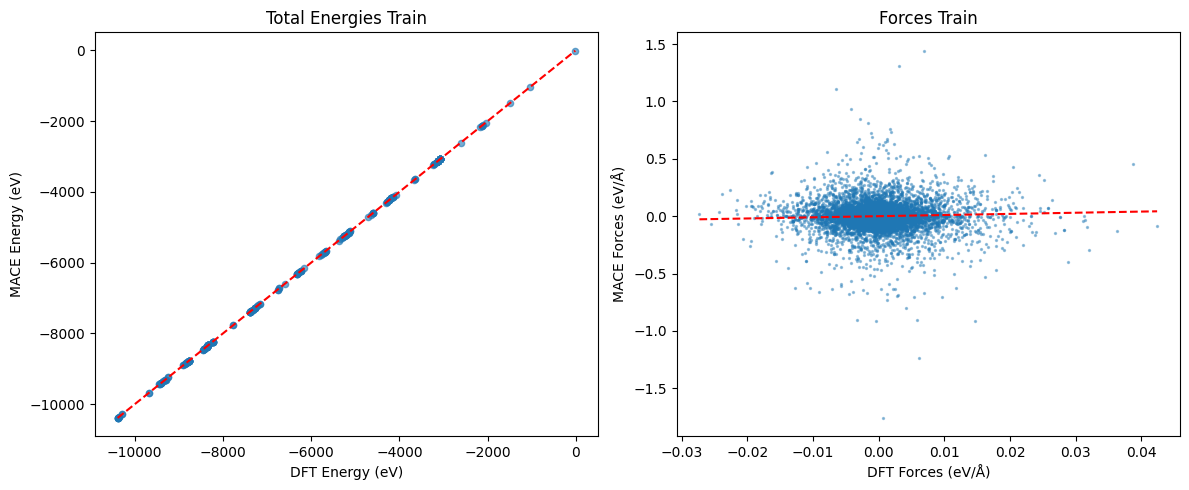

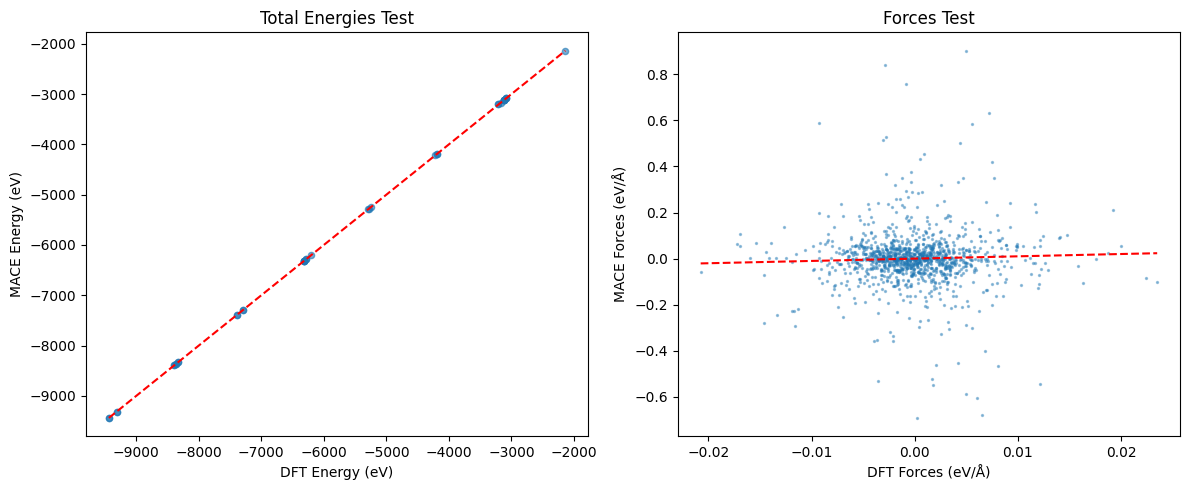

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

def plot_energy_forces(db, label=''):
    # Extraer energías
    E_DFT = np.array([at.info['energy_dft'] for at in db])
    E_MACE = np.array([at.info['MACE_energy'] for at in db])

    # Extraer fuerzas
    F_DFT = np.concatenate([at.arrays['forces_dft'] for at in db]).flatten()
    F_MACE = np.concatenate([at.arrays['MACE_forces'] for at in db]).flatten()

    # Graficar energías
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.scatter(E_DFT, E_MACE, s=20, alpha=0.6)
    plt.plot([E_DFT.min(), E_DFT.max()], [E_DFT.min(), E_DFT.max()], 'r--')
    plt.xlabel('DFT Energy (eV)')
    plt.ylabel('MACE Energy (eV)')
    plt.title(f'Total Energies {label}')

    # Graficar fuerzas
    plt.subplot(1,2,2)
    plt.scatter(F_DFT, F_MACE, s=2, alpha=0.4)
    plt.plot([F_DFT.min(), F_DFT.max()], [F_DFT.min(), F_DFT.max()], 'r--')
    plt.xlabel('DFT Forces (eV/Å)')
    plt.ylabel('MACE Forces (eV/Å)')
    plt.title(f'Forces {label}')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Leer datasets
# -----------------------------
train_data = read('tests/RXN_TEST/rain.xyz', ':')
#val_data = read('validation.xyz', ':')
test_data = read('tests/RXN_TEST/test.xyz', ':')

# -----------------------------
# Graficar comparaciones
# -----------------------------
plot_energy_forces(train_data, label='Train')
#plot_energy_forces(val_data, label='Validation')
plot_energy_forces(test_data, label='Test')


Train | reactant MAE = 23.929 kcal/mol
Train | transition_state MAE = 21.924 kcal/mol
Train | product MAE = 5.629 kcal/mol


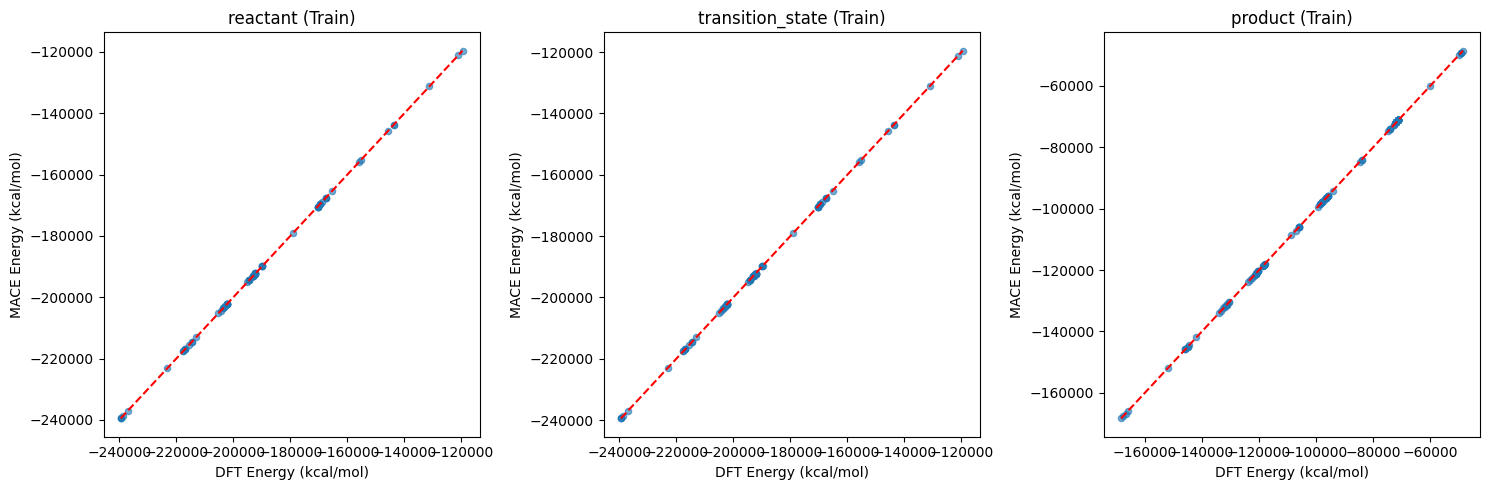

Test | reactant MAE = 22.187 kcal/mol
Test | transition_state MAE = 32.063 kcal/mol
Test | product MAE = 6.519 kcal/mol


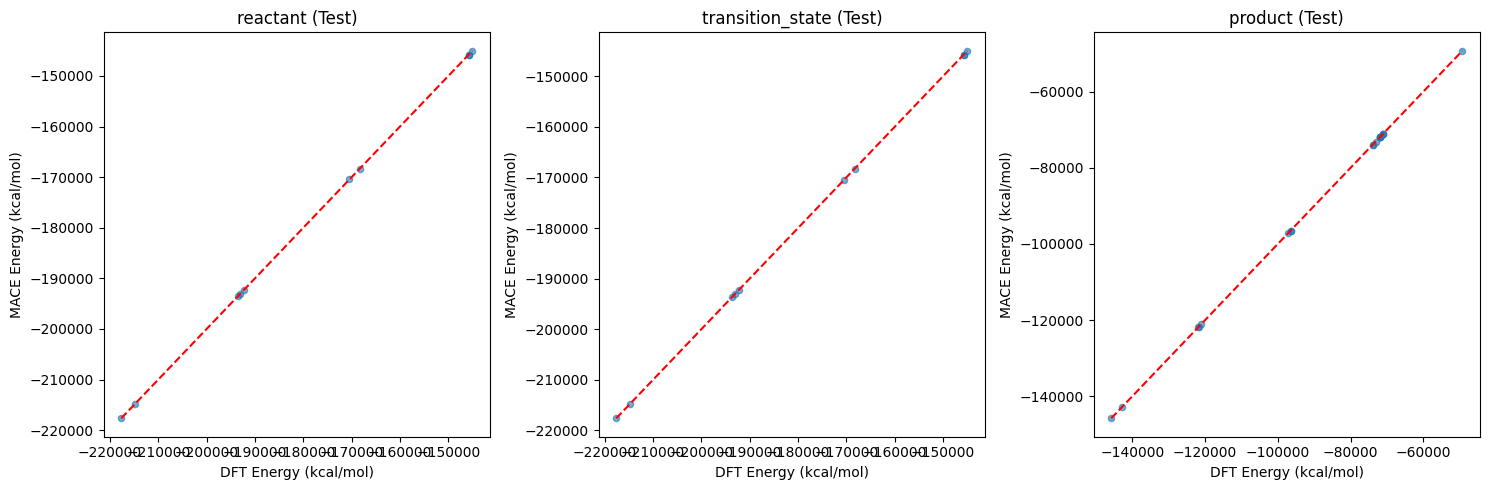

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

# Conversión eV → kcal/mol
EV2KCAL = 23.0609

def plot_energy_MAE_by_type(db, label=''):
    # Tipos de estructuras
    types = ['reactant', 'transition_state', 'product']

    plt.figure(figsize=(15,5))

    for i, t in enumerate(types):
        # Filtrar por tipo
        atoms_t = [at for at in db if at.info['structure_type'] == t]

        if len(atoms_t) == 0:
            continue

        # Extraer energías y convertir
        E_DFT = np.array([at.info['energy_dft'] for at in atoms_t]) * EV2KCAL
        E_MACE = np.array([at.info['MACE_energy'] for at in atoms_t]) * EV2KCAL

        # Calcular MAE
        mae = np.mean(np.abs(E_DFT - E_MACE))
        print(f"{label} | {t} MAE = {mae:.3f} kcal/mol")

        # Scatter plot
        plt.subplot(1,3,i+1)
        plt.scatter(E_DFT, E_MACE, s=20, alpha=0.6)
        plt.plot([E_DFT.min(), E_DFT.max()], [E_DFT.min(), E_DFT.max()], 'r--')
        plt.xlabel('DFT Energy (kcal/mol)')
        plt.ylabel('MACE Energy (kcal/mol)')
        plt.title(f'{t} ({label})')

    plt.tight_layout()
    plt.show()

# -----------------------------
# Leer datasets
# -----------------------------
train_data = read('tests/RXN_TEST/rain.xyz', ':')
#val_data = read('validation.xyz', ':')
test_data = read('tests/RXN_TEST/test.xyz', ':')

# -----------------------------
# Graficar comparaciones
# -----------------------------
plot_energy_MAE_by_type(train_data, label='Train')
#plot_energy_MAE_by_type(val_data, label='Validation')
plot_energy_MAE_by_type(test_data, label='Test')



MAEs Train dataset (kcal/mol):

1,2_Insertion_CO: Barrier MAE = 45.800, ΔH MAE = 19.468
2+2_cycloaddition: Barrier MAE = 44.582, ΔH MAE = 14.014


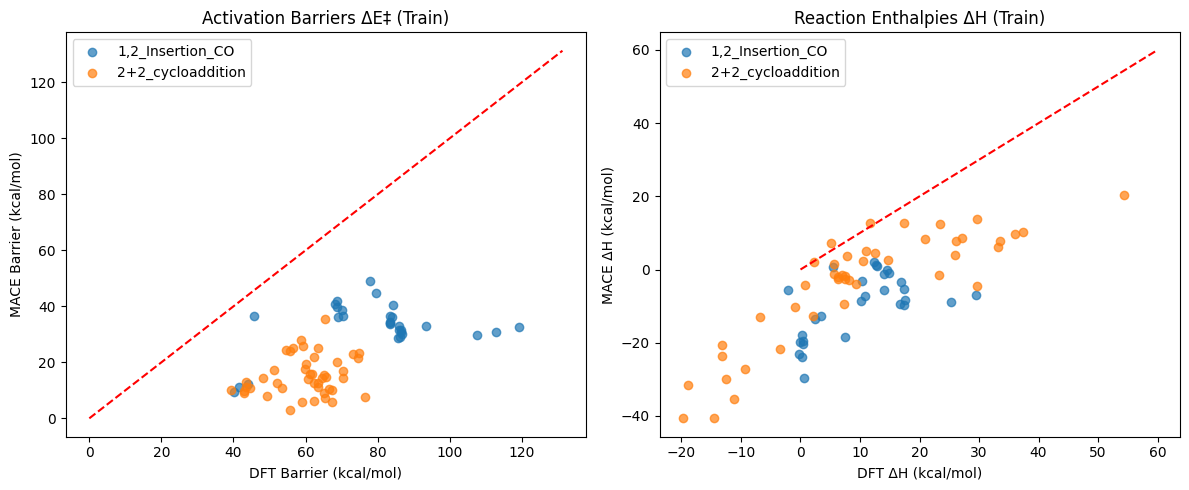


MAEs Test dataset (kcal/mol):

1,2_Insertion_CO: Barrier MAE = 66.721, ΔH MAE = 18.918
2+2_cycloaddition: Barrier MAE = 46.694, ΔH MAE = 11.640


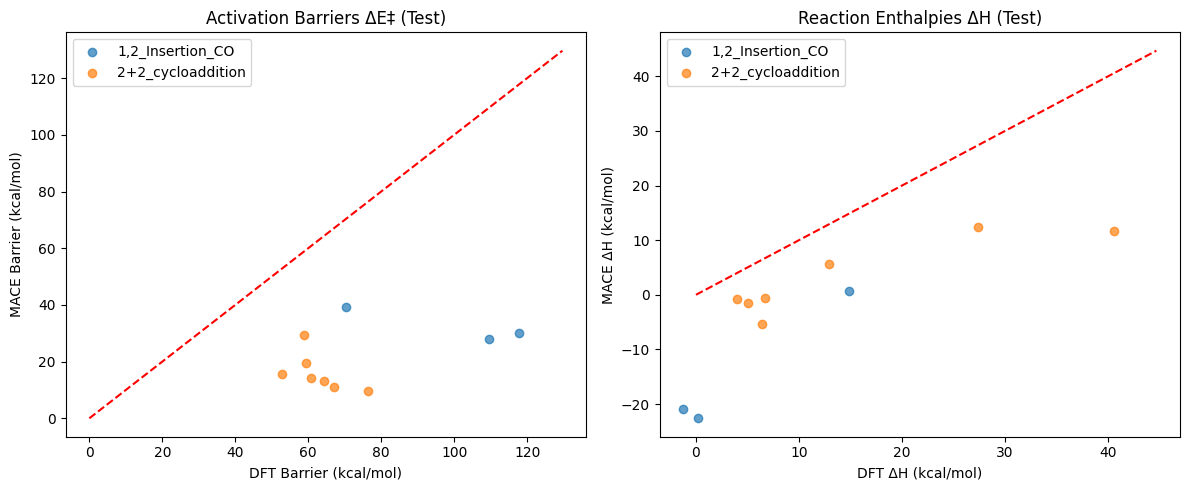

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read
from collections import defaultdict

EV2KCAL = 23.0609  # conversión eV → kcal/mol

# -----------------------------
# Función para calcular barreras y entalpías
# -----------------------------
def compute_barriers_entalpies(db):
    rxn_dict = defaultdict(list)
    for at in db:
        rxn_dict[at.info['reaction_id']].append(at)

    results = []
    for rxn_id, atoms in rxn_dict.items():
        # Separar por tipo
        R_atoms = [at for at in atoms if at.info['structure_type'] == 'reactant']
        TS_atoms = [at for at in atoms if at.info['structure_type'] == 'transition_state']
        P_atoms = [at for at in atoms if at.info['structure_type'] == 'product']

        if len(R_atoms) == 0 or len(TS_atoms) == 0 or len(P_atoms) == 0:
            continue

        # Energía reactivo promedio (si hay varias geometrías)
        E_R_DFT = np.mean([at.info['energy_dft'] for at in R_atoms])
        E_R_MACE = np.mean([at.info['MACE_energy'] for at in R_atoms])

        # Energía TS promedio
        E_TS_DFT = np.mean([at.info['energy_dft'] for at in TS_atoms])
        E_TS_MACE = np.mean([at.info['MACE_energy'] for at in TS_atoms])

        # Energía de productos: sumamos todas las energías de productos de la reacción
        E_P_DFT = sum([at.info['energy_dft'] for at in P_atoms])
        E_P_MACE = sum([at.info['MACE_energy'] for at in P_atoms])

        # Barrera y entalpía
        barrier_DFT = (E_TS_DFT - E_R_DFT) * EV2KCAL
        barrier_MACE = (E_TS_MACE - E_R_MACE) * EV2KCAL
        deltaH_DFT = (E_P_DFT - E_R_DFT) * EV2KCAL
        deltaH_MACE = (E_P_MACE - E_R_MACE) * EV2KCAL

        rxn_type = R_atoms[0].info.get('reaction_type', 'unknown')

        results.append({
            'reaction_id': rxn_id,
            'reaction_type': rxn_type,
            'barrier_DFT': barrier_DFT,
            'barrier_MACE': barrier_MACE,
            'deltaH_DFT': deltaH_DFT,
            'deltaH_MACE': deltaH_MACE
        })
    return results

# -----------------------------
# Función para imprimir MAEs
# -----------------------------
def print_MAEs(results, label=''):
    types = set([r['reaction_type'] for r in results])
    print(f"\nMAEs {label} dataset (kcal/mol):\n")
    for t in types:
        r_type = [r for r in results if r['reaction_type'] == t]
        barrier_MAE = np.mean([abs(r['barrier_DFT'] - r['barrier_MACE']) for r in r_type])
        deltaH_MAE = np.mean([abs(r['deltaH_DFT'] - r['deltaH_MACE']) for r in r_type])
        print(f"{t}: Barrier MAE = {barrier_MAE:.3f}, ΔH MAE = {deltaH_MAE:.3f}")

# -----------------------------
# Función para graficar scatter
# -----------------------------
def plot_barriers_entalpies(results, label=''):
    types = set([r['reaction_type'] for r in results])
    plt.figure(figsize=(12,5))

    # Barreras
    plt.subplot(1,2,1)
    for t in types:
        r_type = [r for r in results if r['reaction_type']==t]
        plt.scatter([r['barrier_DFT'] for r in r_type],
                    [r['barrier_MACE'] for r in r_type],
                    label=t, alpha=0.7)
    plt.plot([0, max([r['barrier_DFT'] for r in results])*1.1],
             [0, max([r['barrier_DFT'] for r in results])*1.1],
             'r--')
    plt.xlabel('DFT Barrier (kcal/mol)')
    plt.ylabel('MACE Barrier (kcal/mol)')
    plt.title(f'Activation Barriers ΔE‡ ({label})')
    plt.legend()

    # Entalpías
    plt.subplot(1,2,2)
    for t in types:
        r_type = [r for r in results if r['reaction_type']==t]
        plt.scatter([r['deltaH_DFT'] for r in r_type],
                    [r['deltaH_MACE'] for r in r_type],
                    label=t, alpha=0.7)
    plt.plot([0, max([r['deltaH_DFT'] for r in results])*1.1],
             [0, max([r['deltaH_DFT'] for r in results])*1.1],
             'r--')
    plt.xlabel('DFT ΔH (kcal/mol)')
    plt.ylabel('MACE ΔH (kcal/mol)')
    plt.title(f'Reaction Enthalpies ΔH ({label})')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -----------------------------
# Leer datasets de evaluación
# -----------------------------
train_data = read('tests/RXN_TEST/rain.xyz', ':')
test_data = read('tests/RXN_TEST/test.xyz', ':')

# -----------------------------
# Evaluación Train
# -----------------------------
train_results = compute_barriers_entalpies(train_data)
print_MAEs(train_results, label='Train')
plot_barriers_entalpies(train_results, label='Train')

# -----------------------------
# Evaluación Test
# -----------------------------
test_results = compute_barriers_entalpies(test_data)
print_MAEs(test_results, label='Test')
plot_barriers_entalpies(test_results, label='Test')
